# 오버워치 2 점수판 분석 AI

In [1]:
import pandas as pd


def prepare_scoreboard(defeat, victory):
    scoreboard = pd.concat([defeat, victory])
    scoreboard.set_index(pd.Index((i, j) for i in range(len(scoreboard) // 10) for j in range(10)), inplace=True)
    return scoreboard

In [2]:
import os

datapath = os.path.join('datasets', '')

In [3]:
# 주피터에 그래프를 깔끔하게 그리기 위해서
import matplotlib as mpl

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [4]:
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import SGDClassifier

# 데이터 적재
defeat = pd.read_csv(datapath + 'defeat.csv', index_col=0)
victory = pd.read_csv(datapath + 'victory.csv', index_col=0)

# 데이터 준비
scoreboard = prepare_scoreboard(defeat, victory)
X = np.c_[scoreboard[['E', 'A', 'D', 'DMG', 'H', 'MIT']]].reshape((-1, 60))
y = np.c_[scoreboard['GAME']][::10].ravel()

# 모델 선택
sgd_clf = SGDClassifier(n_jobs=-1, early_stopping=True)

# 모델 훈련
sgd_clf.fit(X, y)

SGDClassifier(early_stopping=True, n_jobs=-1)

In [5]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X, y, n_jobs=-1)

array([0.51724138, 0.51724138, 0.5       , 0.5       , 0.57142857])

In [6]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X, y)

SVC()

In [7]:
cross_val_score(svm_clf, X, y, n_jobs=-1)

array([0.5862069 , 0.68965517, 0.57142857, 0.75      , 0.5       ])

In [8]:
scoreboard.head(10)

TEAM     ROLE   E   A   D   DMG     H   MIT     GAME
0 0     1     TANK   7   3   6  5933  1068  6199   DEFEAT
  1     1   DAMAGE   7   0  10  3601   747     0   DEFEAT
  2     1   DAMAGE   9   1   6  4352     0     0   DEFEAT
  3     1  SUPPORT   7   7   2  2332  6325     0   DEFEAT
  4     1  SUPPORT   6   4   2  3410  5979   606   DEFEAT
  5     2     TANK  14   0   4  4553     0  7781  VICTORY
  6     2   DAMAGE  16   0   3  6120     0  1271  VICTORY
  7     2   DAMAGE  17   0   3  7512  1215     0  VICTORY
  8     2  SUPPORT  15  16   2  4726  6868     0  VICTORY
  9     2  SUPPORT   7  12   1   856  6071   173  VICTORY

In [9]:
scoreboard.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1420 entries, (0, 0) to (141, 9)
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   TEAM    1420 non-null   int64 
 1   ROLE    1420 non-null   object
 2   E       1420 non-null   int64 
 3   A       1420 non-null   int64 
 4   D       1420 non-null   int64 
 5   DMG     1420 non-null   int64 
 6   H       1420 non-null   int64 
 7   MIT     1420 non-null   int64 
 8   GAME    1420 non-null   object
dtypes: int64(7), object(2)
memory usage: 109.6+ KB


In [10]:
scoreboard['GAME'].value_counts()

GAME
DEFEAT     710
VICTORY    710
Name: count, dtype: int64

In [11]:
scoreboard.describe()

,TEAM,E,A,D,DMG,H,MIT
count,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000
mean,1.500000,13.526056,7.380986,6.209859,6188.401408,3848.818310,2281.254930
std,0.500176,9.722073,8.312217,3.746877,4424.310755,5164.099569,4547.848012
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,6.000000,1.000000,3.000000,2683.250000,0.000000,0.000000
50%,1.500000,12.000000,4.000000,6.000000,5295.500000,759.500000,244.000000
75%,2.000000,20.000000,12.000000,9.000000,9403.500000,7409.750000,1805.000000
max,2.000000,52.000000,45.000000,21.000000,26666.000000,27756.000000,28366.000000


In [15]:
import matplotlib.pyplot as plt

# 그림을 저장할 위치
PROJECT_ROOT_DIR = '.'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images')
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print('그림 저장:', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, dpi=resolution, format=fig_extension)

그림 저장: attribute_histogram_plots


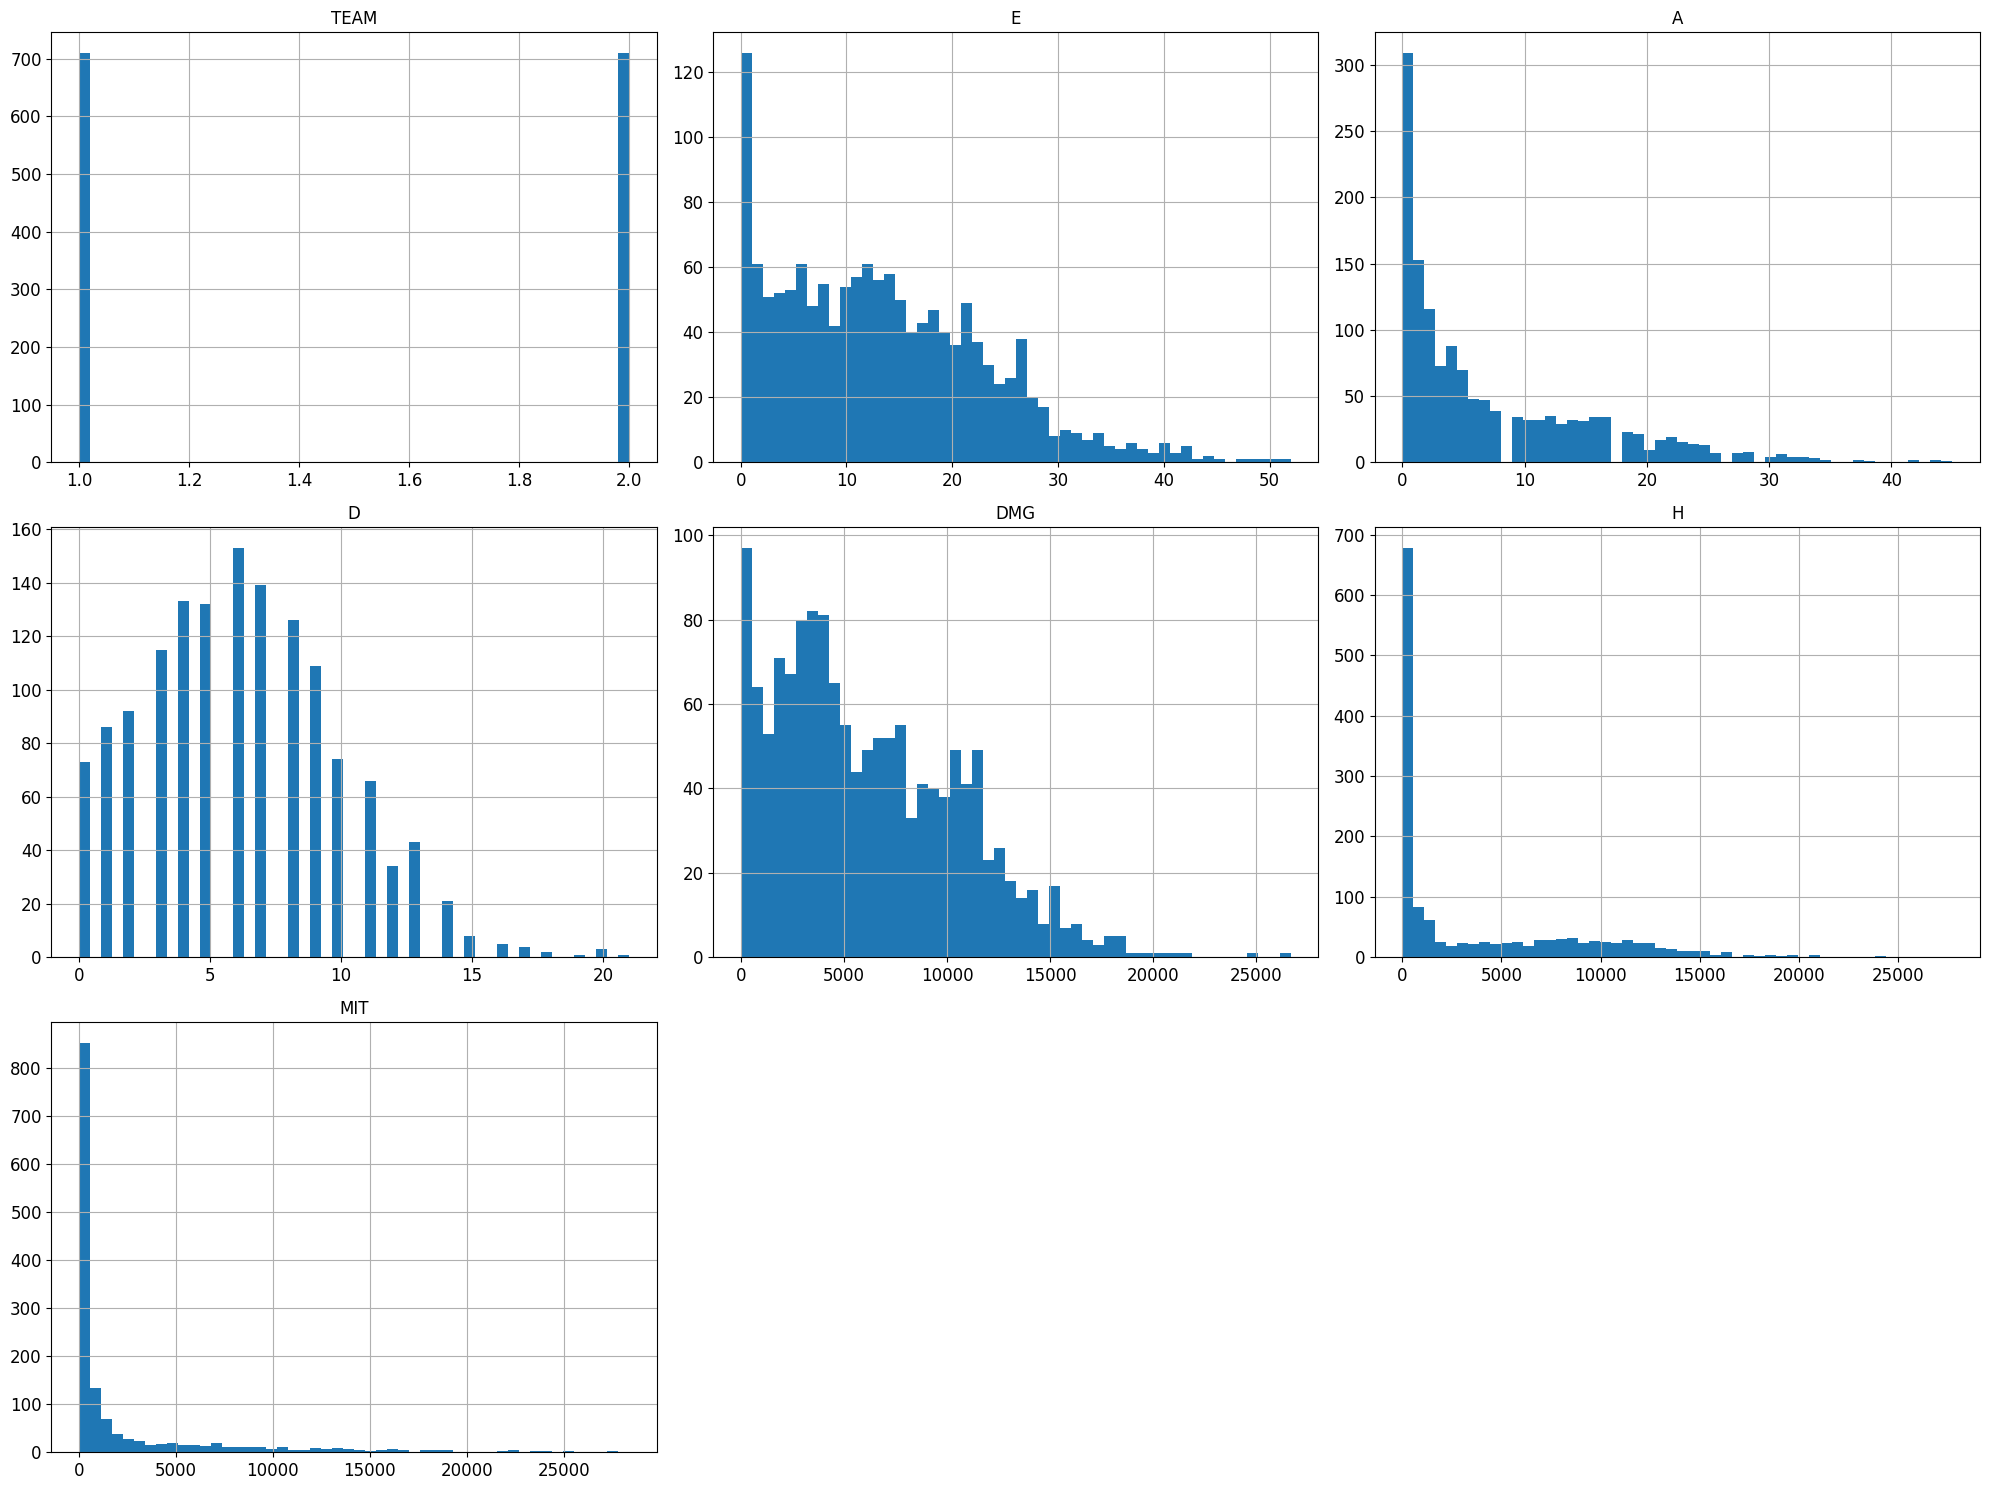

In [16]:
scoreboard.hist(bins=50, figsize=(20, 15))
save_fig('attribute_histogram_plots')
plt.show()

In [23]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(1)
for train_index, test_index in split.split(scoreboard, scoreboard['GAME']):
    strat_train_set = scoreboard.loc[train_index[train_index % 10 == 0] // 10]
    strat_test_set = scoreboard.loc[test_index[test_index % 10 == 0] // 10]

In [25]:
strat_test_set['GAME'].value_counts() / len(strat_test_set)

GAME
DEFEAT     0.5
VICTORY    0.5
Name: count, dtype: float64

In [26]:
scoreboard['GAME'].value_counts() / len(scoreboard)

GAME
DEFEAT     0.5
VICTORY    0.5
Name: count, dtype: float64

In [27]:
scoreboard = strat_train_set.copy()

In [29]:
scoreboard.corr(numeric_only=True)

,TEAM,E,A,D,DMG,H,MIT
TEAM,1.000000,-0.178078,-0.130233,0.126093,-0.015160,-0.019877,-0.019364
E,-0.178078,1.000000,-0.047195,0.264661,0.815243,-0.276568,0.334378
A,-0.130233,-0.047195,1.000000,-0.042920,-0.293709,0.828606,-0.084450
D,0.126093,0.264661,-0.042920,1.000000,0.463854,0.006756,0.064497
DMG,-0.015160,0.815243,-0.293709,0.463854,1.000000,-0.456804,0.427078
H,-0.019877,-0.276568,0.828606,0.006756,-0.456804,1.000000,-0.265976
MIT,-0.019364,0.334378,-0.084450,0.064497,0.427078,-0.265976,1.000000
